In [9]:
import os
import keras
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
import requests
import shutil
import urllib
import math

# for notification after long-running code-cell
from IPython.display import Audio
wave = np.sin(2*np.pi*400*np.arange(10000*2)/10000)

main_dir = "/Users/jonas/Documents/art-classification"

#Now let us read metadata to get our Y values (multiple lables)
#os.chdir("/Users/jonas/Documents/art-classification/")
df = pd.read_csv(main_dir+'/data/wikiart_scraped.csv')
print(df.head())     # printing first five rows of the file
print(df.columns)
#print(df["Style"].unique())

styles = ["Abstract-Art", "Abstract-Expressionism", "Academicism", "Art-Informel", "Art-Nouveau-(Modern)", "Baroque","Cubism", "Color-Field-Painting", "Conceptual-Art", "Expressionism", "Impressionism", "Mannerism-(Late-Renaissance)", "Minimalism", "Naïve-Art-(Primitivism)", "Pop-Art", "Post-Impressionism", "Neoclassicism", "Neo-Expressionism", "Northern-Renaissance", "Realism", "Rococo", "Romanticism", "Surrealism", "Symbolism"]

df = df[df["Style"].isin(styles)]


image_directory = main_dir + "/data/img"
os.chdir(image_directory)


df = df[df.Date.str.isnumeric()] # only accept numeric dates
df["Date"] = pd.to_numeric(df["Date"])
df = df[df["Date"]>=1000]

# exact year to decade
df["Date"] = df["Date"].apply(lambda x: (math.floor(x/10))*10)

df=pd.get_dummies(df, columns=["Style", "Date"])

df["id"] = df.index
#df["idx"] = df["idx"].astype(str) + ".jpg"
#print(df)

X = np.array(df["id"])


#Id and Genre are not labels to be trained. So drop them from the dataframe.
#No need to convert to categorical as the dataset is already in the right format.
#y = np.array(df.drop(['Style', 'Artwork', 'Artist', 'Date', 'Link'], axis=1))
y = np.array(df.drop(['Artwork', 'Artist', 'Link', 'id'], axis=1))
print(len(y))
print(y)

            Style                                    Artwork         Artist  \
0  Early-Dynastic                             Narmer Palette  Ancient Egypt   
1  Early-Dynastic         Box Inlay with a Geometric Pattern  Ancient Egypt   
2     Old-Kingdom                           Khafre Enthroned  Ancient Egypt   
3  Middle-Kingdom  Stele of the Serpent King (Stela of Djet)  Ancient Egypt   
4  Middle-Kingdom  Laden Donkeys and Ploughing, Tomb of Djar  Ancient Egypt   

           Date                                               Link  
0       3050 BC  https://uploads3.wikiart.org/00265/images/anci...  
1  3100-2900 BC  https://uploads2.wikiart.org/00244/images/anci...  
2       2570 BC  https://uploads2.wikiart.org/00305/images/anci...  
3       3000 BC  https://uploads7.wikiart.org/00305/images/anci...  
4  2060-2010 BC  https://uploads8.wikiart.org/00244/images/anci...  
Index(['Style', 'Artwork', 'Artist', 'Date', 'Link'], dtype='object')
58249
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 

In [10]:
import tensorflow as tf
os.chdir(main_dir)
!mkdir -p models
os.chdir(main_dir+"/models")
csv_logger = tf.keras.callbacks.CSVLogger(os.getcwd()+"/multi-50ep-2.csv", separator=",", append=True)
decades = [col for col in df if col.startswith("Date_")]
print(decades)

['Date_1410', 'Date_1420', 'Date_1430', 'Date_1440', 'Date_1450', 'Date_1460', 'Date_1470', 'Date_1480', 'Date_1490', 'Date_1500', 'Date_1510', 'Date_1520', 'Date_1530', 'Date_1540', 'Date_1550', 'Date_1560', 'Date_1570', 'Date_1580', 'Date_1590', 'Date_1600', 'Date_1610', 'Date_1620', 'Date_1630', 'Date_1640', 'Date_1660', 'Date_1670', 'Date_1680', 'Date_1690', 'Date_1700', 'Date_1710', 'Date_1720', 'Date_1730', 'Date_1740', 'Date_1750', 'Date_1760', 'Date_1770', 'Date_1780', 'Date_1790', 'Date_1800', 'Date_1810', 'Date_1820', 'Date_1830', 'Date_1840', 'Date_1850', 'Date_1860', 'Date_1870', 'Date_1880', 'Date_1890', 'Date_1900', 'Date_1910', 'Date_1920', 'Date_1930', 'Date_1940', 'Date_1950', 'Date_1960', 'Date_1970', 'Date_1980', 'Date_1990', 'Date_2000', 'Date_2010', 'Date_2020']


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)

#X_train_df = pd.DataFrame(X_train, columns=["name"])
#X_test_df = pd.DataFrame(X_test, columns=["name"])
train_df = df.loc[X_train].drop(['Artwork', 'Artist', 'Link'], axis=1)
train_df["id"] = train_df["id"].astype(str) + ".jpg"
test_df = df.loc[X_test].drop(['Artwork', 'Artist', 'Link'], axis=1)
test_df["id"] = test_df["id"].astype(str) + ".jpg"

style_labels = [col for col in df if (col.startswith("Style_"))]
labels = [col for col in df if (col.startswith("Date_") or col.startswith("Style_"))]

print(y_train)
print(style_labels)
#print(train_df)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['Style_Abstract-Art', 'Style_Abstract-Expressionism', 'Style_Academicism', 'Style_Art-Informel', 'Style_Art-Nouveau-(Modern)', 'Style_Baroque', 'Style_Color-Field-Painting', 'Style_Conceptual-Art', 'Style_Cubism', 'Style_Expressionism', 'Style_Impressionism', 'Style_Mannerism-(Late-Renaissance)', 'Style_Minimalism', 'Style_Naïve-Art-(Primitivism)', 'Style_Neo-Expressionism', 'Style_Neoclassicism', 'Style_Northern-Renaissance', 'Style_Pop-Art', 'Style_Post-Impressionism', 'Style_Realism', 'Style_Rococo', 'Style_Romanticism', 'Style_Surrealism', 'Style_Symbolism']


In [12]:
SIZE = 200

def load_images(names):
    X_dataset = []
    for name in names:
        img = image.image_utils.load_img(image_directory + "\\" + str(name) + '.jpg', target_size=(SIZE,SIZE,3))
        img = image.image_utils.img_to_array(img)
        img = img/255.
        X_dataset.append(img)
    return np.array(X_dataset)
X_train = load_images(X_train)
X_test = load_images(X_test)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jonas/Documents/art-classification/data/img\\7912.jpg'

In [20]:
from keras import Input
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
import functools
newModel = False
continue_training = False
modelpath = "/Users/jonas/Documents/art-classification/models/multi_model/multi-50ep"
modelpath2 = "/Users/jonas/Documents/art-classification/models/multi_model/old_format.h5"

SIZE = 200
epochs = 50
batch_size = 64

train_loss = [] # to append when training in batches
train_acc_style = []
train_acc_decade = []

"""
def load_images(names):
    X_dataset = []
    for name in names:
        img = image.image_utils.load_img(image_directory + "/" + str(name) + '.jpg', target_size=(SIZE,SIZE,3))
        img = image.image_utils.img_to_array(img)
        img = img/255.
        X_dataset.append(img)
    return np.array(X_dataset)

datagen=ImageDataGenerator(rescale=1./255)
train_generator_decade=datagen.flow_from_dataframe(dataframe=train_df, directory=image_directory, x_col="id", y_col=decades, class_mode="raw", target_size=(SIZE,SIZE), batch_size=batch_size)
test_generator_decade=datagen.flow_from_dataframe(dataframe=test_df, directory=image_directory, x_col="id", y_col=decades, class_mode="raw", target_size=(SIZE,SIZE), batch_size=batch_size)
"""
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'

top5_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'

if newModel:

    input_layer = Input(shape=(SIZE,SIZE,3))

    conv1 = Conv2D(filters=16, kernel_size=(5, 5), activation="relu")(input_layer)
    bn1 = BatchNormalization()(conv1)
    mp1 = MaxPooling2D(pool_size=(2, 2))(bn1)
    dropout1 = Dropout(0.2)(mp1)

    conv2 = Conv2D(filters=32, kernel_size=(5, 5), activation='relu')(dropout1)
    mp2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    bn2 = BatchNormalization()(mp2)
    dropout2 = Dropout(0.2)(bn2)

    conv3 = Conv2D(filters=64, kernel_size=(5, 5), activation="relu")(dropout2)
    mp3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    bn3 = BatchNormalization()(mp3)
    dropout3 = Dropout(0.2)(bn3)

    conv4 = Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(dropout3)
    mp4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    bn4 = BatchNormalization()(mp4)
    dropout4 = Dropout(0.2)(bn4)

    flatten = Flatten()(dropout4)
    dense1 = Dense(128, activation='relu')(flatten)
    dropout5 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation='relu')(dropout5)
    dropout6 = Dropout(0.5)(dense2)

    y1_output = Dense(len(styles), activation='softmax', name='style_output')(dropout6)
    y2_output = Dense(len(decades), activation='softmax', name='decade_output')(dropout6)
    #model.add(Dense(len(styles)+len(decades), activation='sigmoid')) # changed from 25 to 1 so I get no error

    model = keras.Model(inputs=input_layer, outputs=[y1_output, y2_output])

    model.summary()

    #Binary cross entropy of each label. So no really a binary classification problem but
    #Calculating binary cross entropy for each label.
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics={'style_output':['accuracy', top3_acc, top5_acc],
                           'decade_output':['accuracy', top3_acc, top5_acc]})

    history = model.fit(X_train,
                        [y_train[:,0:len(styles)], y_train[:,len(styles):]],
                        epochs=epochs,
                        validation_data=(X_test, [y_test[:,0:len(styles)], y_test[:,len(styles):]]),
                        batch_size=batch_size,
                        callbacks=[csv_logger])

    # save model
    !mkdir -p multi_model
    model.save('multi_model/multi-50ep')

else:
    model = keras.models.load_model(modelpath2,
                                    #custom_objects = {"top5_acc": top5_acc, "top3_acc": top3_acc},
                                    compile=False)
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics={'style_output':['accuracy', top3_acc, top5_acc],
                       'decade_output':['accuracy', top3_acc, top5_acc]})
    if continue_training:
        datagen=ImageDataGenerator(rescale=1./255)
        train_generator_style=datagen.flow_from_dataframe(dataframe=train_df, directory=image_directory, x_col="id", y_col=style_labels, class_mode="raw", target_size=(SIZE,SIZE), batch_size=batch_size)
        test_generator_style=datagen.flow_from_dataframe(dataframe=test_df, directory=image_directory, x_col="id", y_col=style_labels, class_mode="raw", target_size=(SIZE,SIZE), batch_size=batch_size)

        history = model.fit(train_generator_style,
                            epochs=epochs,
                            validation_data=test_generator_style,
                            batch_size=batch_size,
                            callbacks=[csv_logger])
        #history = model.evaluate(X_test, y_test, verbose=2)
        #history.history=history

        model.save('style/continued2')

In [21]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 196, 196, 16  1216        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 196, 196, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

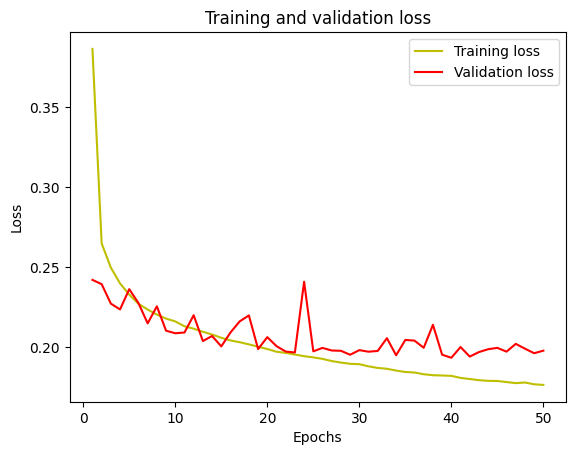

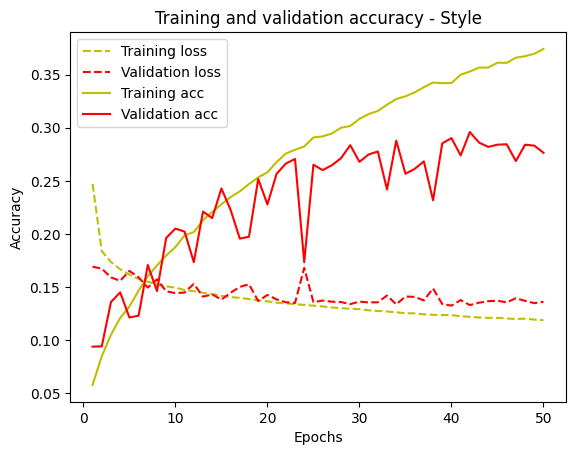

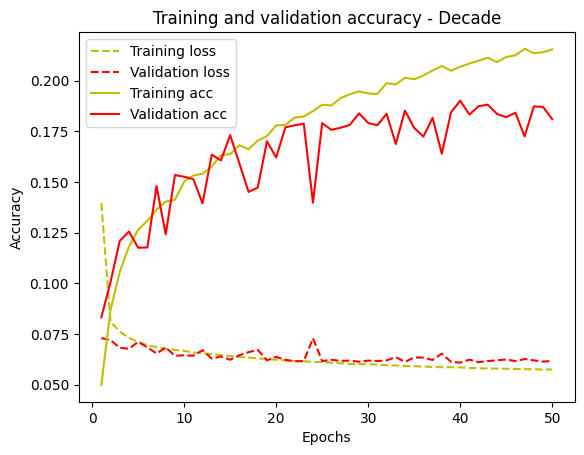

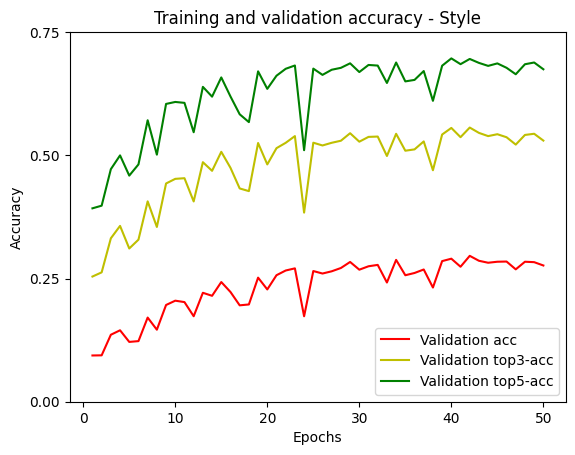

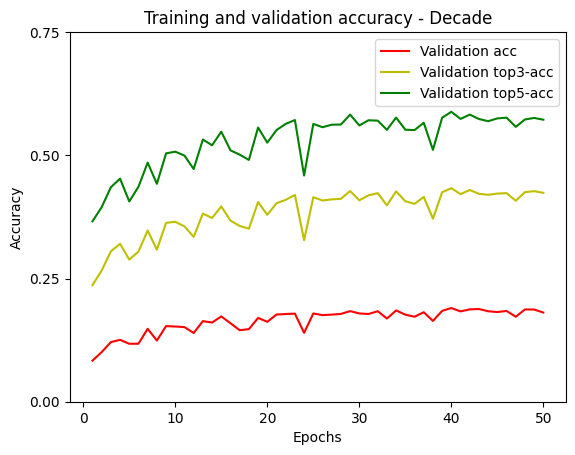

In [17]:
plot_with_loss=True
from_csv = True
filepath = main_dir+"/models/multi-50ep.csv"
if from_csv:
    history = pd.read_csv(filepath, header=0)
    # epoch (starts at 0 for each new training) | acc | loss | val_acc | val_loss
    # with topk:
    # epoch,accuracy,loss,top3_acc,top5_acc,val_accuracy,val_loss,val_top3_acc,val_top5_acc
    #print(history)
    decade_output_accuracy = np.array(history["decade_output_accuracy"])
    decade_output_loss = np.array(history["decade_output_loss"])
    decade_output_top3_acc = np.array(history["decade_output_top3_acc"])
    decade_output_top5_acc = np.array(history["decade_output_top5_acc"])
    loss = np.array(history["loss"])
    style_output_accuracy = np.array(history["style_output_accuracy"])
    style_output_loss = np.array(history["style_output_loss"])
    style_output_top3_acc = np.array(history["style_output_top3_acc"])
    style_output_top5_acc = np.array(history["style_output_top5_acc"])
    val_decade_output_accuracy = np.array(history["val_decade_output_accuracy"])
    val_decade_output_loss = np.array(history["val_decade_output_loss"])
    val_decade_output_top3_acc = np.array(history["val_decade_output_top3_acc"])
    val_decade_output_top5_acc = np.array(history["val_decade_output_top5_acc"])
    val_loss = np.array(history["val_loss"])
    val_style_output_accuracy = np.array(history["val_style_output_accuracy"])
    val_style_output_loss = np.array(history["val_style_output_loss"])
    val_style_output_top3_acc = np.array(history["val_style_output_top3_acc"])
    val_style_output_top5_acc = np.array(history["val_style_output_top5_acc"])
else:
    #plot the training and validation accuracy and loss at each epoch
    decade_output_accuracy = history.history["decade_output_accuracy"]
    decade_output_loss = history.history["decade_output_loss"]
    decade_output_top3_acc = history.history["decade_output_top3_acc"]
    decade_output_top5_acc = history.history["decade_output_top5_acc"]
    loss = history.history["loss"]
    style_output_accuracy = history.history["style_output_accuracy"]
    style_output_loss = history.history["style_output_loss"]
    style_output_top3_acc = history.history["style_output_top3_acc"]
    style_output_top5_acc = history.history["style_output_top5_acc"]
    val_decade_output_accuracy = history.history["val_decade_output_accuracy"]
    val_decade_output_loss = history.history["val_decade_output_loss"]
    val_decade_output_top3_acc = history.history["val_decade_output_top3_acc"]
    val_decade_output_top5_acc = history.history["val_decade_output_top5_acc"]
    val_loss = history.history["val_loss"]
    val_style_output_accuracy = history.history["val_style_output_top3_acc"]
    val_style_output_loss = history.history["val_style_output_loss"]
    val_style_output_top3_acc = history.history["val_style_output_top3_acc"]
    val_style_output_top5_acc = history.history["val_style_output_top5_acc"]

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

if plot_with_loss:
    plt.plot(epochs, style_output_loss, 'y', label='Training loss', linestyle='dashed')
    plt.plot(epochs, val_style_output_loss, 'r', label='Validation loss', linestyle='dashed')
plt.plot(epochs, style_output_accuracy, 'y', label='Training acc')
plt.plot(epochs, val_style_output_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy - Style')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

if plot_with_loss:
    plt.plot(epochs, decade_output_loss, 'y', label='Training loss', linestyle='dashed')
    plt.plot(epochs, val_decade_output_loss, 'r', label='Validation loss', linestyle='dashed')
plt.plot(epochs, decade_output_accuracy, 'y', label='Training acc')
plt.plot(epochs, val_decade_output_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy - Decade')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_style_output_accuracy, 'r', label='Validation acc')
plt.plot(epochs, val_style_output_top3_acc, 'y', label='Validation top3-acc')
plt.plot(epochs, val_style_output_top5_acc, 'g', label='Validation top5-acc')
plt.title('Training and validation accuracy - Style')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.yticks(np.arange(0, 1, 0.25))
plt.show()


#plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_decade_output_accuracy, 'r', label='Validation acc')
plt.plot(epochs, val_decade_output_top3_acc, 'y', label='Validation top3-acc')
plt.plot(epochs, val_decade_output_top5_acc, 'g', label='Validation top5-acc')
plt.title('Training and validation accuracy - Decade')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.yticks(np.arange(0, 1, 0.25))
plt.show()



In [24]:
# load test images

def load_images(names):
    X_dataset = []
    for name in names:
        img = image.image_utils.load_img(image_directory + "/" + str(name) + '.jpg', target_size=(SIZE,SIZE,3))
        img = image.image_utils.img_to_array(img)
        img = img/255.
        X_dataset.append(img)
    return np.array(X_dataset)
X_test = load_images(X_test)

In [0]:
# COnfusion Matrix
from sklearn.metrics import confusion_matrix

test1_predictions, test2_predictions = model.predict(X_test)

In [30]:
y1_train = y_train[:,0:len(styles)]
y2_train = y_train[:,len(styles):]
y1_test = y_test[:,0:len(styles)]
y2_test = y_test[:,len(styles):]

cm_style = confusion_matrix(y1_test.argmax(axis=1),test1_predictions.argmax(axis=1))
print(cm_style)

[[  0 129   0   0  23   0  35  11  79  14   7   0  13   8   0   0   1  44
    9   2   0   1  78  14]
 [  0 351   1   0  60   3 105  29  40  27  14   4  42  19   0   0  12  66
   37  11   0   3 114  36]
 [  0   5  72   0  46  32   0   2   0   7  27  46   0   0   0   1  17   0
   14 106  30  36  25  51]
 [  0 152   0   0  30   2  37  12  31  21   9   2  17  10   0   0   2  22
   24  10   0   3  47  20]
 [  0  79   6   0 395   7   3  23  12  41  37   6  10  28   0   0  20  28
   66  23   2   8 130  86]
 [  0   9  18   0  34 238   2   2   1   8  18 125   1   1   0   1  30   0
    8 125  60  30  25  51]
 [  1  69   0   0   0   0 308   5   5   2   0   0  33   0   0   0   0  13
    1   2   0   0   3   1]
 [  0  91   1   0  57   4  41  75  12   5  12   4  49   1   0   1   6  23
   13  18   2   3 119  20]
 [  0  61   0   0  45   3   7   5 299 121  14   9   2  12   0   1  16  45
   53   4   0   4 156  28]
 [  0  74   6   0 105   3   6   6  70 262  56   8   6  20   1   1  18  14
  109  30   0   9

[Text(0, 0.5, 'Abstract-Art'),
 Text(0, 1.5, 'Abstract-Expressionism'),
 Text(0, 2.5, 'Academicism'),
 Text(0, 3.5, 'Art-Informel'),
 Text(0, 4.5, 'Art-Nouveau-(Modern)'),
 Text(0, 5.5, 'Baroque'),
 Text(0, 6.5, 'Color-Field-Painting'),
 Text(0, 7.5, 'Conceptual-Art'),
 Text(0, 8.5, 'Cubism'),
 Text(0, 9.5, 'Expressionism'),
 Text(0, 10.5, 'Impressionism'),
 Text(0, 11.5, 'Mannerism-(Late-Renaissance)'),
 Text(0, 12.5, 'Minimalism'),
 Text(0, 13.5, 'Naïve-Art-(Primitivism)'),
 Text(0, 14.5, 'Neo-Expressionism'),
 Text(0, 15.5, 'Neoclassicism'),
 Text(0, 16.5, 'Northern-Renaissance'),
 Text(0, 17.5, 'Pop-Art'),
 Text(0, 18.5, 'Post-Impressionism'),
 Text(0, 19.5, 'Realism'),
 Text(0, 20.5, 'Rococo'),
 Text(0, 21.5, 'Romanticism'),
 Text(0, 22.5, 'Surrealism'),
 Text(0, 23.5, 'Symbolism')]

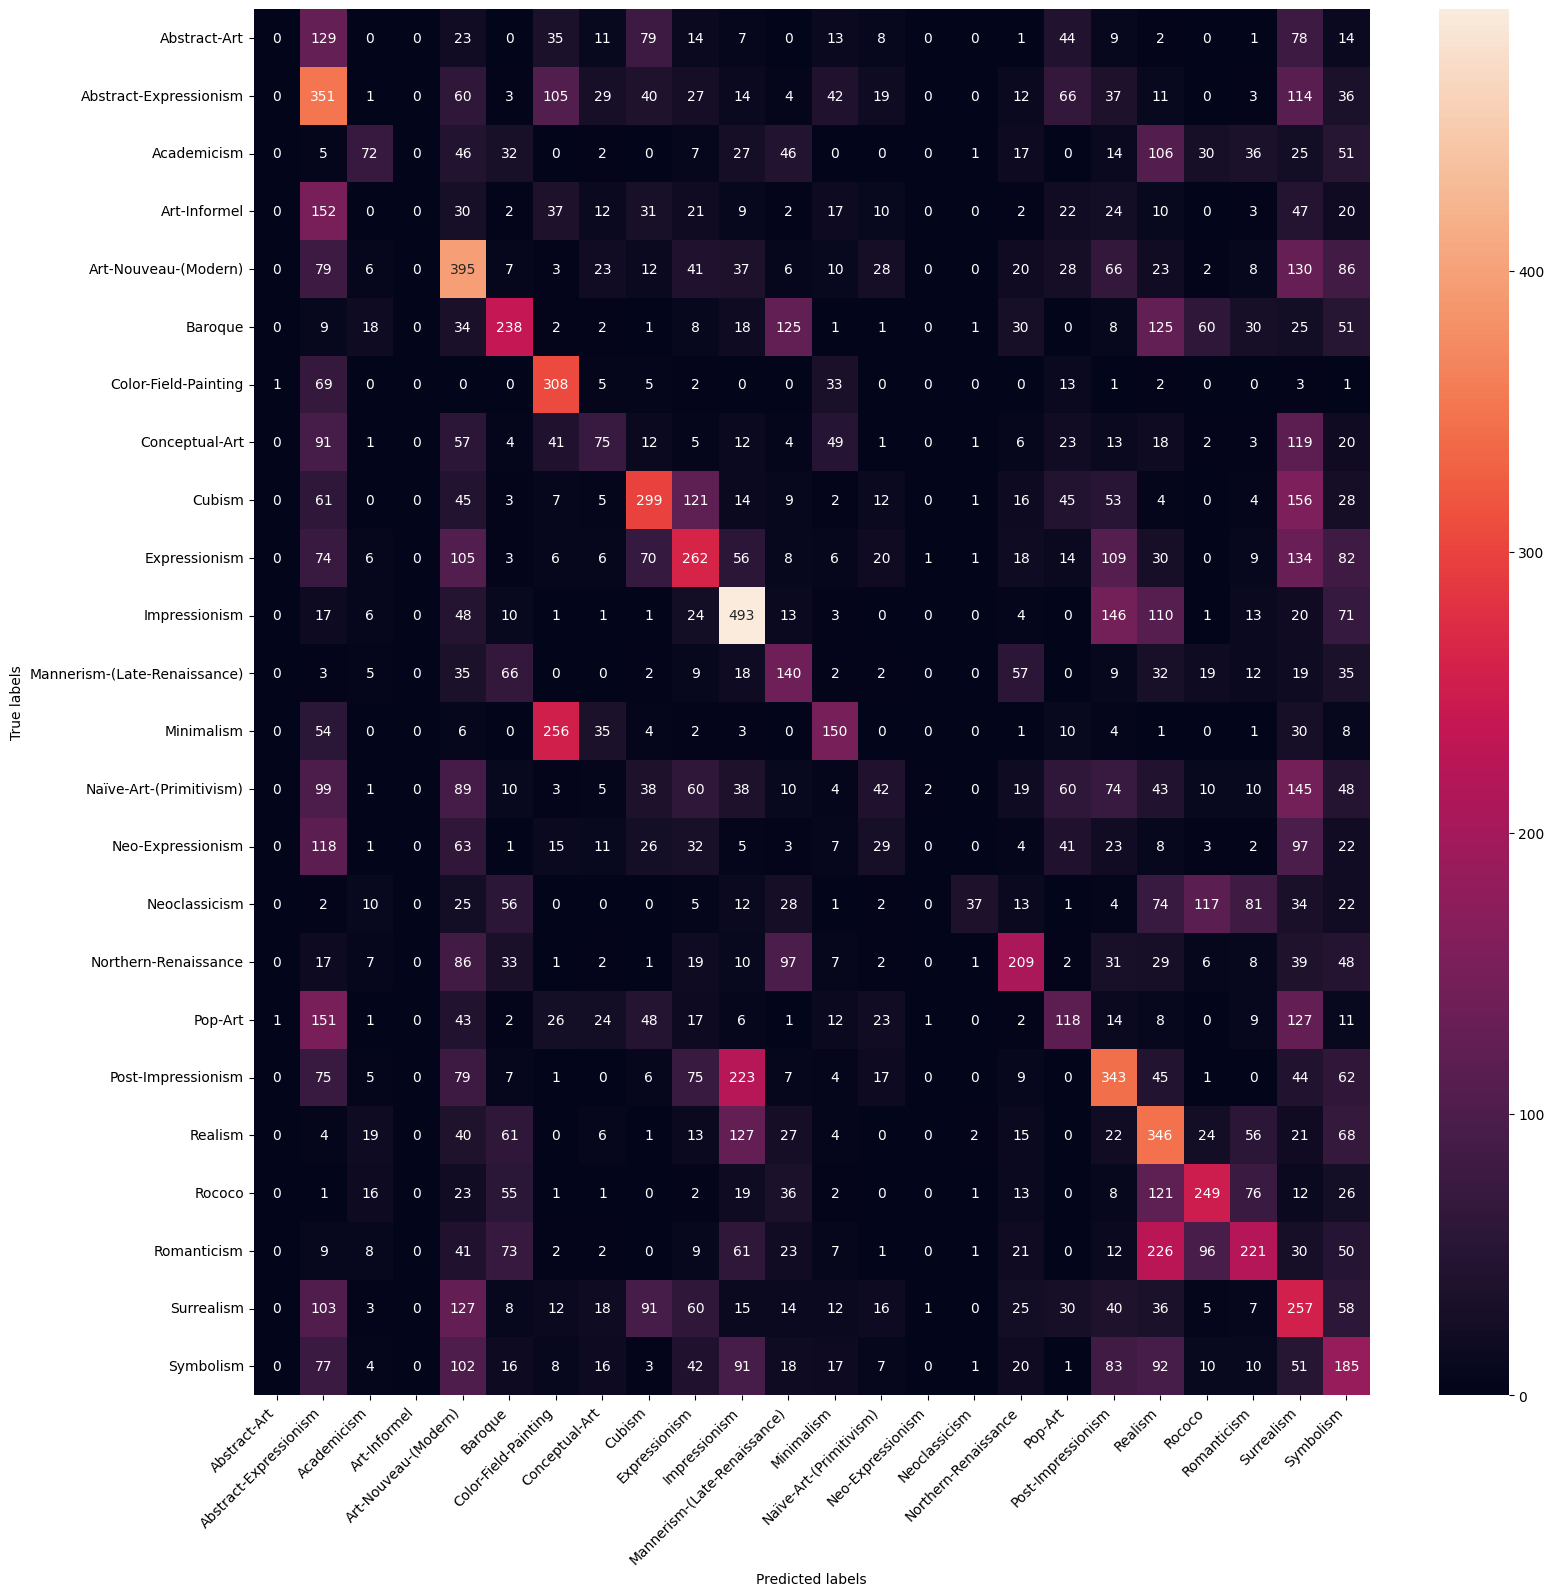

In [37]:

import seaborn as sns

# Plot Style Confusion Matrix
f = plt.figure(figsize=(18,18))
ax=f.add_subplot()
sns.heatmap(cm_style, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
style_labels = [col for col in df if (col.startswith("Style_"))]
plt.xticks(rotation = 90, ticks=np.arange(0.5,len(style_labels)+0.5))
plt.yticks(rotation = 0, ticks=np.arange(0.5,len(style_labels)+0.5))
ax.set_xlabel("Predicted labels"); ax.set_ylabel("True labels")
ax.xaxis.set_ticklabels(map(lambda x: x.replace('Style_',''),style_labels),
                        rotation=45,
                        horizontalalignment='right')
ax.yaxis.set_ticklabels(map(lambda x: x.replace('Style_',''),style_labels))

In [38]:
decades.pop(27)
decades.pop(26)

'Date_1680'

[Text(0, 0.5, '1410'),
 Text(0, 1.5, '1420'),
 Text(0, 2.5, '1430'),
 Text(0, 3.5, '1440'),
 Text(0, 4.5, '1450'),
 Text(0, 5.5, '1460'),
 Text(0, 6.5, '1470'),
 Text(0, 7.5, '1480'),
 Text(0, 8.5, '1490'),
 Text(0, 9.5, '1500'),
 Text(0, 10.5, '1510'),
 Text(0, 11.5, '1520'),
 Text(0, 12.5, '1530'),
 Text(0, 13.5, '1540'),
 Text(0, 14.5, '1550'),
 Text(0, 15.5, '1560'),
 Text(0, 16.5, '1570'),
 Text(0, 17.5, '1580'),
 Text(0, 18.5, '1590'),
 Text(0, 19.5, '1600'),
 Text(0, 20.5, '1610'),
 Text(0, 21.5, '1620'),
 Text(0, 22.5, '1630'),
 Text(0, 23.5, '1640'),
 Text(0, 24.5, '1660'),
 Text(0, 25.5, '1670'),
 Text(0, 26.5, '1700'),
 Text(0, 27.5, '1710'),
 Text(0, 28.5, '1720'),
 Text(0, 29.5, '1730'),
 Text(0, 30.5, '1740'),
 Text(0, 31.5, '1750'),
 Text(0, 32.5, '1760'),
 Text(0, 33.5, '1770'),
 Text(0, 34.5, '1780'),
 Text(0, 35.5, '1790'),
 Text(0, 36.5, '1800'),
 Text(0, 37.5, '1810'),
 Text(0, 38.5, '1820'),
 Text(0, 39.5, '1830'),
 Text(0, 40.5, '1840'),
 Text(0, 41.5, '1850'),
 T

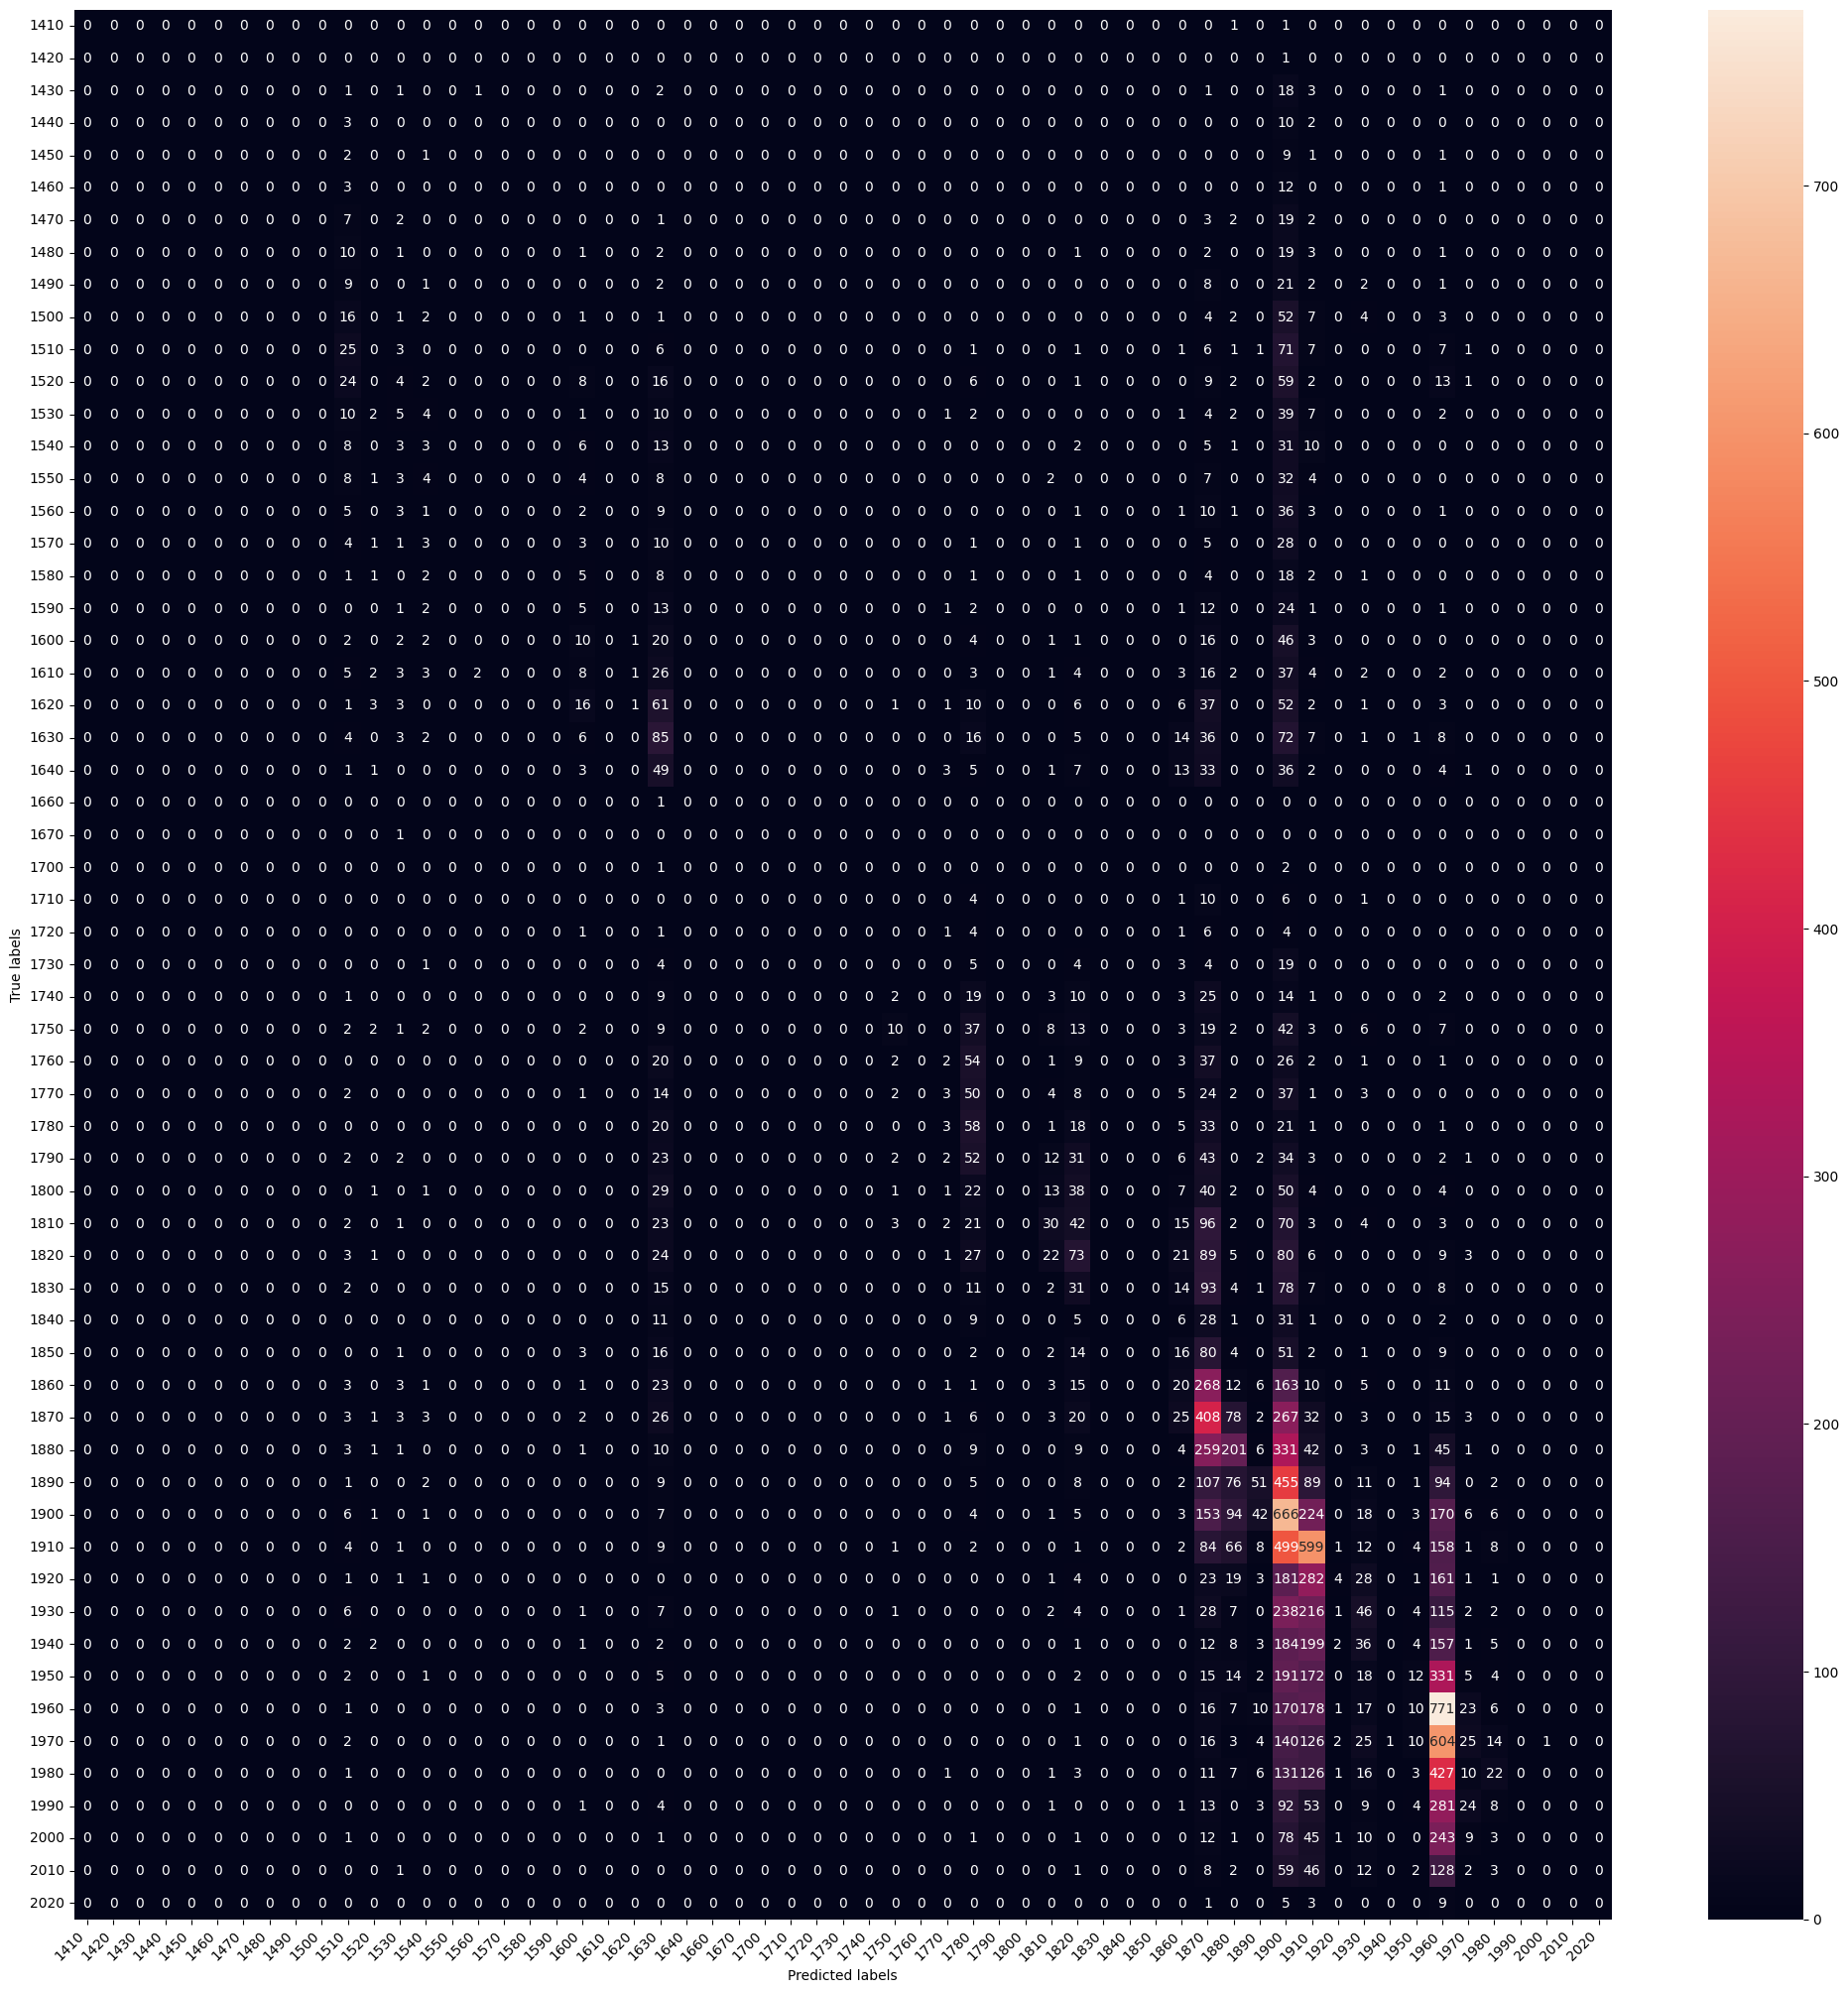

In [39]:
cm_dec = confusion_matrix(y2_test.argmax(axis=1),test2_predictions.argmax(axis=1))

# Plot Decade Confusion Matrix
f = plt.figure(figsize=(25,25))
ax=f.add_subplot()
sns.heatmap(cm_dec, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
plt.xticks(rotation = 90, ticks=np.arange(0.5,len(decades)+.5))
plt.yticks(rotation = 0, ticks=np.arange(0.5,len(decades)+.5))
ax.set_xlabel("Predicted labels"); ax.set_ylabel("True labels")
ax.xaxis.set_ticklabels(map(lambda x: x.replace('Date_',''),decades),
                        rotation=45,
                        horizontalalignment='right')
ax.yaxis.set_ticklabels(map(lambda x: x.replace('Date_',''),decades))